In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow.keras import utils
import pandas as pd
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# changing to the datas
os.chdir('/kaggle/input/cassava-leaf-disease-classification')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
os.listdir()

['train_tfrecords',
 'sample_submission.csv',
 'test_tfrecords',
 'label_num_to_disease_map.json',
 'train_images',
 'train.csv',
 'test_images']

In [3]:
labelcsv = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')

In [4]:
labelcsv

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [5]:
labels_encoded = utils.to_categorical(labelcsv['label'])

In [6]:
imagelist = labelcsv['image_id']

## Storing all the resized images to a single list

## Loading the image and corresponding label to the tf data api

In [7]:
img_bytes = tf.io.read_file(f'/kaggle/input/cassava-leaf-disease-classification/train_images/1000201771.jpg')

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((imagelist,labels_encoded))

In [28]:
images = []
imagelist = np.array(labelcsv['image_id'])
# pipeline to load image and resize it for my model
def image_to_array(img,label, size=[224,224]):
#     loading image
    # Load the image as bytes
    file_path = tf.strings.join(['/kaggle/input/cassava-leaf-disease-classification/train_images/', img])
    img_extension = tf.strings.lower(tf.strings.split(file_path, '.')[-1])
    img_bytes = tf.io.read_file(file_path)
    # Decode the image (supports jpg, png, etc.)
    img = tf.cond(
        tf.math.equal(img_extension, 'jpg') | tf.math.equal(img_extension, 'jpeg'),
        lambda: tf.image.decode_jpeg(img_bytes, channels=3),
        lambda: tf.image.decode_png(img_bytes, channels=3)
    )
    # Resize the image and normalize it
    img = tf.image.resize(img, size) / 255.0
    return img, label
    

In [10]:
def load_and_preprocess_image_label(img_name, label):
    image = image_to_array(img_name,label)
    return image, label 

In [11]:
# Iterate through the dataset and print the first few batches
for images, labels in dataset.take(1):  # Take the first batch
     print(image_to_array(images,labels))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.12885155, 0.3466687 , 0.44014606],
        [0.1547519 , 0.3461985 , 0.42609045],
        [0.14091636, 0.33404362, 0.36830732],
        ...,
        [0.5675776 , 0.69979054, 0.3442782 ],
        [0.25430077, 0.37106767, 0.10680079],
        [0.1642648 , 0.26329443, 0.11185397]],

       [[0.1252601 , 0.3380252 , 0.38403362],
        [0.14248699, 0.33331332, 0.37133855],
        [0.16785714, 0.35385156, 0.37401965],
        ...,
        [0.40226793, 0.4079402 , 0.32117566],
        [0.36045244, 0.3783095 , 0.21342467],
        [0.5961499 , 0.6304837 , 0.36387694]],

       [[0.10701281, 0.3344638 , 0.3415366 ],
        [0.11239496, 0.32267907, 0.33714485],
        [0.12228892, 0.3222189 , 0.34878954],
        ...,
        [0.10877534, 0.08363529, 0.03420503],
        [0.12023789, 0.09597816, 0.02791127],
        [0.14786963, 0.12784167, 0.03623492]],

       ...,

       [[0.04201681, 0.19103642, 0.        ],
        [0.0

In [12]:
tf.data.experimental.enable_debug_mode()
dataset = dataset.map(load_and_preprocess_image_label, num_parallel_calls=tf.data.AUTOTUNE)

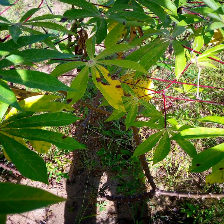

tf.Tensor([1. 0. 0. 0. 0.], shape=(5,), dtype=float64)


In [13]:
from PIL import Image
from IPython.display import display
for images, labels in dataset.take(1):
    pil_img = utils.array_to_img(images[0])
    display(pil_img)
    print(images[1])

# Model Building and Archietecture

In [14]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='softmax')
])


In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [16]:

dataset = dataset.shuffle(buffer_size=5000, seed=42)  


total_size = 21397
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  


train_dataset = dataset.take(train_size)
remaining_dataset = dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size)
test_dataset = remaining_dataset.skip(val_size)


batch_size = 32
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)


train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)


history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)



Epoch 1/10


I0000 00:00:1733873747.954327      92 service.cc:145] XLA service 0x7ec648007480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733873747.954379      92 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733873747.954383      92 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/535 ━━━━━━━━━━━━━━━━━━━━ 14:39:54 99s/step - accuracy: 0.4688 - loss: 1.5990

I0000 00:00:1733873753.524079      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


535/535 ━━━━━━━━━━━━━━━━━━━━ 751s 1s/step - accuracy: 0.6051 - loss: 1.2657 - val_accuracy: 0.6302 - val_loss: 1.0103
Epoch 2/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 621s 1s/step - accuracy: 0.6407 - loss: 0.9739 - val_accuracy: 0.6503 - val_loss: 0.9603
Epoch 3/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.6590 - loss: 0.9096 - val_accuracy: 0.7003 - val_loss: 0.7995
Epoch 4/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - accuracy: 0.6872 - loss: 0.8180 - val_accuracy: 0.7172 - val_loss: 0.7801
Epoch 5/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 630s 1s/step - accuracy: 0.7304 - loss: 0.7090 - val_accuracy: 0.7662 - val_loss: 0.6326
Epoch 6/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 626s 1s/step - accuracy: 0.8142 - loss: 0.5067 - val_accuracy: 0.8331 - val_loss: 0.5119
Epoch 7/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 622s 1s/step - accuracy: 0.9061 - loss: 0.2766 - val_accuracy: 0.8724 - val_loss: 0.3918
Epoch 8/10
535/535 ━━━━━━━━━━━━━━━━━━━━ 619s 1s/step - accuracy: 0.9617 - loss: 0.1222 - val_accuracy: 0.903

In [17]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy:.2f}')

67/67 ━━━━━━━━━━━━━━━━━━━━ 294s 23ms/step - accuracy: 0.9381 - loss: 0.2367
Test accuracy: 0.94


In [33]:
def image_to_arraytest(img,label, size=[224,224]):
#     loading image
    # Load the image as bytes
    file_path = tf.strings.join(['/kaggle/input/cassava-leaf-disease-classification/test_images/', img])
    img_extension = tf.strings.lower(tf.strings.split(file_path, '.')[-1])
    img_bytes = tf.io.read_file(file_path)
    # Decode the image (supports jpg, png, etc.)
    img = tf.cond(
        tf.math.equal(img_extension, 'jpg') | tf.math.equal(img_extension, 'jpeg'),
        lambda: tf.image.decode_jpeg(img_bytes, channels=3),
        lambda: tf.image.decode_png(img_bytes, channels=3)
    )
    # Resize the image and normalize it
    img = tf.image.resize(img, size) / 255.0
    return img, label

In [ ]:
img_arrayed = img_to_arraytest()

In [34]:
def predict_image_class(img_name):
    img, _ = image_to_arraytest(img_name, label=0)  
    img = tf.expand_dims(img, axis=0)
    predictions = model.predict(img)
#     print(predictions)
    predicted_class = tf.argmax(predictions[0]).numpy()

    return predicted_class

# Example usage:
image_name = "2216849948.jpg" 
predicted_class = predict_image_class(image_name)
print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
Predicted class: 3


In [38]:
import pandas as pd
test_images = os.listdir('/kaggle/input/cassava-leaf-disease-classification/test_images')
predictions = []
for img_name in test_images:  
    img, _ = image_to_arraytest(img_name, label=0)  
    img = tf.expand_dims(img, axis=0) 
    pred = model.predict(img)
    predicted_class = tf.argmax(pred[0]).numpy()
    predictions.append((img_name, predicted_class))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [39]:
predictions

[('2216849948.jpg', 3)]

In [40]:

image_ids = []
labels = []


for image_id, label in predictions:
    image_ids.append(image_id)
    labels.append(label)

submission_df = pd.DataFrame({
    'id': image_ids,  
    'label': labels    
})

submission_df.to_csv("/kaggle/working/submission.csv", index=False)
